# Image Segmentation

**motivation**:Train a segmentation neural network on the xray images of the lungs, to get segmented image of the lungs and remove any possible noise.

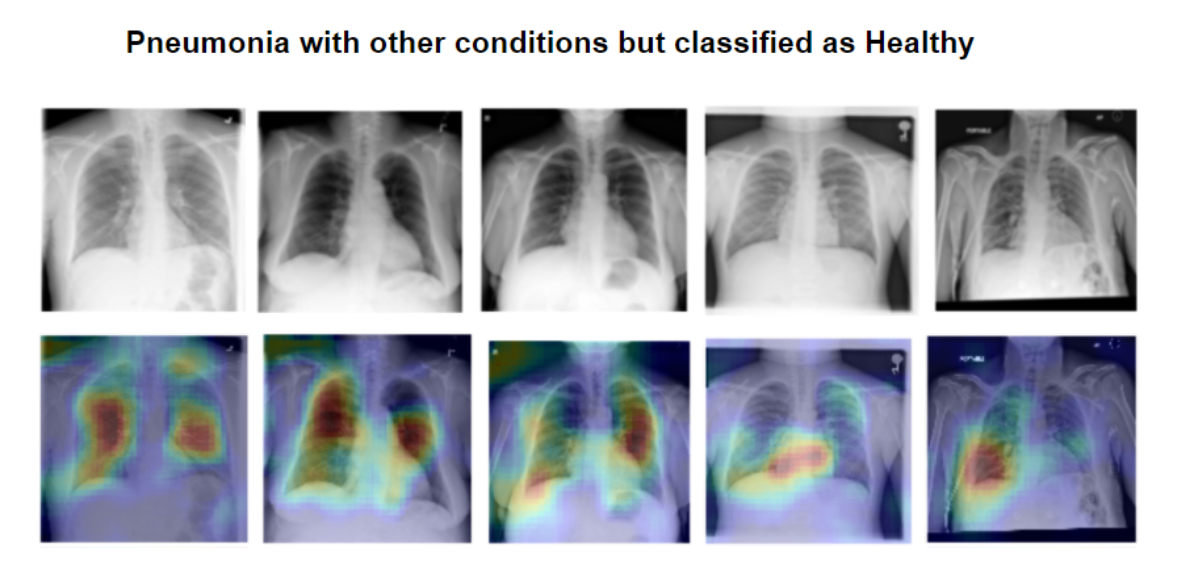

## download the data from kaggle


In [ ]:
# data is in kaggle so to download that need kaggle credentials which is in drive 
# so mount drive 

from google.colab import drive
drive.mount('/content/drive') 

# download data from kaggle 

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/datasets/kaggle/kaggle.json ~/.kaggle/
# ! kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

# # unzip the data 

# ! unzip chest-xray-masks-and-labels.zip

Mounted at /content/drive


## import all the necessary libraries

In [ ]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
import os
import random
import cv2
from PIL import Image
from skimage import io

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt

import argparse
import logging
import os
import sys

import time
import copy

path = '/content/drive/MyDrive/Projects/DS5500/imagesegmentation_checkpoint/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## create a custom torch dataset of the images and the relevant mask

In [ ]:
class LungSegDataset(Dataset): # inherit from torch.utils.data.Dataset
    "Lung sengmentation dataset."
    def __init__(self,root_dir = os.path.join(os.getcwd(),"data/Lung Segmentation"),split = "train", transforms = None , shuffle = True):
        """
        Args:
        :param root_dir (str):
        :param split (str):
        :param transforms (callable, optional) :
        """
        self.root_dir = root_dir
        self.split = split # train / val / test
        self.transforms = transforms

        # data
        # train set : CHN
        # test/validation set : MCU
        self.image_path = self.root_dir + '/CXR_png'
        image_file =  os.listdir(self.image_path)
        self.train_image_file = [fName for fName in image_file if "CHNCXR" in fName]
        self.train_image_idx = sorted([int(fName.split("_")[1]) for fName in self.train_image_file])

        self.eval_image_file = [fName for fName in image_file if "MCUCXR" in fName]
        self.eval_image_idx = sorted([int(fName.split("_")[1]) for fName in self.eval_image_file])

        # target
        self.mask_path = os.path.join(self.root_dir,'masks')
        mask_file = os.listdir(self.mask_path)
        self.train_mask_file = [fName for fName in mask_file if "CHNCXR" in fName]
        self.train_mask_idx = sorted([int(fName.split("_")[1]) for fName in self.train_mask_file])

        self.eval_mask_file = [fName for fName in mask_file if "MCUCXR" in fName]
        self.eval_mask_idx = sorted([int(fName.split("_")[1]) for fName in self.eval_mask_file])

        # train/ val / test
        # for train set, we use CHN
        # for test and validation set, we use MCU
        self.train_idx = [idx for idx in self.train_image_idx if idx in self.train_mask_idx]
        self.eval_idx = [idx for idx in self.eval_image_idx if idx in self.eval_mask_idx]
        self.val_idx = self.eval_idx[:int(0.5*len(self.eval_idx))]
        self.test_idx = self.eval_idx[int(0.5*len(self.eval_idx)):]

        self.data_file = {"train"  : {"image":self.train_image_file , "mask": self.train_mask_file},
                           "val"   : {"image":self.eval_image_file  , "mask": self.eval_mask_file },
                           "test"  : {"image":self.eval_image_file  , "mask": self.eval_mask_file}}

        self.data_idx ={"train" : self.train_idx,
                        "val"   : self.val_idx,
                        "test"  : self.test_idx}

    def __len__(self):
        return len(self.data_idx[self.split])

    def __getitem__(self, idx):
        idx = self.data_idx[self.split][idx]
        # set index
        for fName in self.data_file[self.split]["image"]:
            file_idx = int(fName.split('_')[1])
            if idx == file_idx:
                img_fName = fName
        img_path = os.path.join(self.image_path, img_fName)
        img = Image.open(img_path).convert('LA')  # open as PIL Image and set Channel = 1

        for fName in self.data_file[self.split]["mask"]:
            file_idx = int(fName.split('_')[1])
            if idx == file_idx:
                mask_fName = fName
        mask_path = os.path.join(self.mask_path, mask_fName)
        mask = Image.open(mask_path)  # PIL Image

        sample = {'image': img, 'mask': mask}

        if self.transforms:
            sample = self.transforms(sample)

        if isinstance(img,torch.Tensor) and isinstance(mask, torch.Tensor):
            assert img.size == mask.size
        return sample

## Model (UNET)

We want to to filter out lungs from the image. UNET achieves excellent results on image partitioning. So we will use UNET to segment the lungs.

In [ ]:
class UNetConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3 , padding = True):
        super().__init__()
        self.double_conv = nn.Sequential(
            # Usually Conv -> BatchNormalization -> Activation
            nn.Conv2d(in_channels , out_channels , kernel_size= kernel_size , padding = int(padding)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=int(padding)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self,inp):
        return self.double_conv(inp)

class Down(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            UNetConvBlock(in_channels,out_channels)
        )

    def forward(self,x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self,in_channels , out_channels , bilinear = False):
        super(Up,self).__init__()

        if bilinear: # use the normal conv to reduce the number of channels
            self.up = nn.Upsample(scale_factor=2, mode= 'bilinear', align_corners = True)
        else: # use Transpose convolution (the one that official UNet used)
            self.up = nn.ConvTranspose2d(in_channels//2 , in_channels // 2, kernel_size = 2,stride=2 )

        self.conv = UNetConvBlock(in_channels,out_channels)

    def forward(self,x1,x2):
        # input dim is CHW
        x1 = self.up(x1)

        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1 , [diffX // 2, diffX - diffX // 2,
                         diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1] , dim = 1)
        out = self.conv(x)
        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

unet architecture straight from the paper

https://arxiv.org/abs/1505.04597

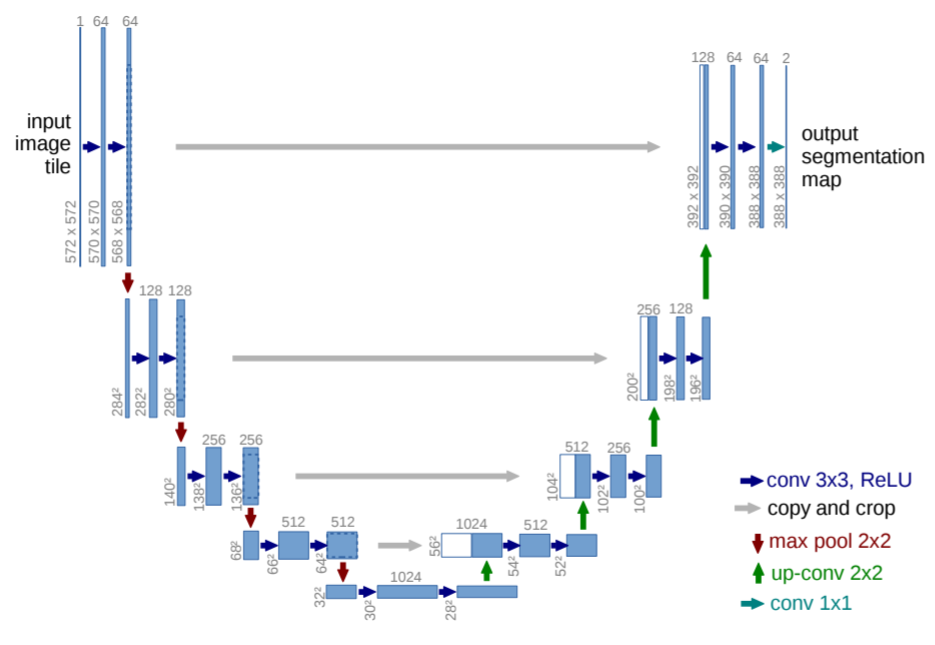

## Architecture

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes , bilinear = False):
        super(UNet,self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.in_conv = UNetConvBlock(self.n_channels , 64)
        self.Down1 = Down(64 , 128)
        self.Down2 = Down(128, 256)
        self.Down3 = Down(256, 512)
        self.Down4 = Down(512, 512)
        self.Up1 = Up(512 + 512, 256 , self.bilinear)
        self.Up2 = Up(256 + 256, 128 , self.bilinear)
        self.Up3 = Up(128 + 128 , 64 , self.bilinear)
        self.Up4 = Up(64 + 64, 64 , self.bilinear)
        self.out_conv = OutConv(64, n_classes)

    def forward(self,x):
        x1 = self.in_conv(x)
        x2 = self.Down1(x1)
        x3 = self.Down2(x2)
        x4 = self.Down3(x3)
        x5 = self.Down4(x4)
        x = self.Up1(x5,x4)
        x = self.Up2(x ,x3)
        x = self.Up3(x ,x2)
        x = self.Up4(x ,x1)
        out = self.out_conv(x)
        return out

#UNet(3,10)

## Transforms

In [ ]:
class GrayScale(object):
    def __call__(self,sample):
        from torchvision.transforms import Grayscale
        Grayscale = Grayscale()
        sample['image'] = Grayscale(sample['image'])
        return sample

class Resize(object):
    """
    Resize the input PIL Image to the given size.
    """
    def __init__(self,img_size):
        assert isinstance(img_size , (int,tuple))
        self.img_size = img_size

    def __call__(self,sample):
        img , mask = sample['image'],sample['mask']
        Resize = transforms.Resize((self.img_size,self.img_size))
        sample['image'],sample['mask'] = Resize(img), Resize(mask)
        return sample

class RandomRotation(object):
    def __init__(self, degrees, resample=False, expand=False, center=None, fill=0):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center
        self.fill = fill

    @staticmethod
    def get_params(degrees):
        angle = random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, img):
        angle = self.get_params(self.degrees)
        return F.rotate(img, angle, self.resample, self.expand, self.center, self.fill)

    def __repr__(self):
        format_string = self.__class__.__name__ + '(degrees={0}'.format(self.degrees)
        format_string += ', resample={0}'.format(self.resample)
        format_string += ', expand={0}'.format(self.expand)
        if self.center is not None:
            format_string += ', center={0}'.format(self.center)
        format_string += ')'
        return format_string


class ColorJitter(object):
    def __init__(self,brightness=0, contrast=0, saturation=0, hue=0):
        from torchvision.transforms import ColorJitter
        self.ColorJitter = ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self,sample):
        return {"image":self.ColorJitter(sample["image"]),
                "mask" :sample["mask"]}

class ToTensor(object):
    """convert ndarrays in sample to Tensors"""
    def __call__(self,sample):
        from torchvision.transforms import ToTensor
        ToTensor = ToTensor()
        img , mask = sample['image'],sample['mask']
        sample['image'],sample['mask'] = ToTensor(img) ,ToTensor(mask)
        return sample

class RandomVerticalFlip(object):
    def __init__(self, p =0.5):
        self.p = p
    def __call__(self,sample):
        from torchvision.transforms.functional import vflip as vertical_flip
        img , mask = sample['image'],sample['mask']
        if random.random() < self.p:
                sample['image'], sample['mask'] = vertical_flip(img), vertical_flip(mask)
        return sample

class RandomHorizontalFlip(object):
    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, sample):
        from torchvision.transforms.functional import hflip as horizontal_flip
        img , mask = sample['image'],sample['mask']
        if random.random() < self.p:
                sample['image'], sample['mask'] = horizontal_flip(img), horizontal_flip(mask)
        return sample

class ToPILImage(object):
    def __call__(self,sample):
        from torchvision.transforms import ToPILImage
        img , mask = sample['image'],sample['mask']
        ToPILImage = ToPILImage()
        sample['image'], sample['mask'] = ToPILImage(img),ToPILImage(mask)
        return sample

## Train and Validate 

In [ ]:
def train_and_validate(net,criterion, optimizer, scheduler, dataloader,device,epochs, load_model = None):

    """load checkpoint pt"""
    if load_model:
        print("load model from", load_model)
        # net.load_state_dict(torch.load(load_model))
        checkpoint = torch.load(load_model)
        net.load_state_dict(checkpoint['model_state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss = checkpoint['loss']

    history = {'train':{'epoch':[], 'loss' : [] , 'acc':[]},
               'val'  :{'epoch':[], 'loss' : [] , 'acc':[]}}

    best_acc = 0.90
    best_loss = 10000000000
    start = time.time()
    for epoch in range(epochs):
        if load_model:
            epoch += start_epoch
            epochs += start_epoch
        print("-" * 30)
        print(f"Epoch {epoch + 1}/{epochs}")
    
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # set model to training mode
            else:
                print("-" * 10)
                net.eval() # set model to evaluate mode

            running_loss = 0.0
            running_correct = 0
            dataset_size = 0
            """Iterate over data"""
            for batch_idx, sample in enumerate(dataloader[phase]):
                imgs , true_masks = sample['image'],sample['mask']
                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32
                true_masks = true_masks.to(device=device, dtype=mask_type)

                # zero the parameter gradients
                optimizer.zero_grad()

                """forward"""
                with torch.set_grad_enabled(phase == 'train'):
                    masks_pred = net(imgs)
                    loss = criterion(masks_pred, true_masks)
                    running_loss += loss.item()

                    """backward + optimize only if in training phase"""
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                """ statistics """
                dataset_size += imgs.size(0)
                running_loss += loss.item() * imgs.size(0)
                pred = torch.sigmoid(masks_pred) > 0.5
                running_correct += (pred == true_masks).float().mean().item() * imgs.size(0)
                running_acc = running_correct/dataset_size

            """ statistics """
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_correct / dataset_size
            print('{} Loss {:.5f}\n{} Acc {:.2f}'
                  .format(phase, epoch_loss,phase,epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                torch.save({
                    'epoch':epoch + 1,
                    'model_state_dict':best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc
                },os.path.join(path,'best_checkpoint[epoch_{}].pt'.format(epoch + 1)))
                print("Achived best result! save checkpoint.")
                print("val acc = ", best_acc)
            history[phase]['epoch'].append(epoch)
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)

        scheduler.step(history['val']['acc'][-1])

        time_elapsed = time.time() - since
        print("One Epoch Complete in {:.0f}m {:.0f}s".format(time_elapsed//60 , time_elapsed%60))

        time_elapsed = time.time() - start
        min, sec = time_elapsed//60 , time_elapsed % 60
        print("Total Training time {:.0f}min {:.0f}sec".format(min,sec))

## Model arguments

In [ ]:
def get_args():

    parser = argparse.ArgumentParser(description = "U-Net for Lung Segmentation" ,
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # set your environment
    parser.add_argument('--gpu', type=str, default = '0')
    parser.add_argument('--n_workers', type =int , default = 4 , help = "The number of workers for dataloader")

    # arguments for training
    parser.add_argument('--img_size', type = int , default = 512,)
    parser.add_argument('--epochs', type=int , default = 50 )
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.1)

    parser.add_argument('--load_model', type=str, default=None, help='.pth file path to load model')
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

    return parser.parse_args()

## Model setup

In [ ]:
args = get_args()

# set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu # default: '0'

# set model
model = UNet(n_channels=1, n_classes=1).to(device)
if len(args.gpu) > 1: # if multi-gpu
    model = torch.nn.DataParallel(model)

img_size = args.img_size #default: 512

# set transforms for dataset
train_transforms = transforms.Compose([
    #Data Augmentations
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    GrayScale(),
    Resize(img_size),
    ToTensor(),

])
eval_transforms = transforms.Compose([
    GrayScale(),
    Resize(img_size),
    ToTensor()
])

# set Dataset and DataLoader
train_dataset = LungSegDataset(transforms=train_transforms)
val_dataset = LungSegDataset(split='val',transforms=eval_transforms)
test_dataset = LungSegDataset(split = 'test',transforms=eval_transforms)

from torch.utils.data import DataLoader
dataloader = {'train' : DataLoader(dataset = train_dataset, batch_size=args.batch_size, num_workers=args.n_workers, shuffle=True),
              'val' :   DataLoader(dataset = val_dataset  , batch_size=args.batch_size, num_workers=args.n_workers, shuffle=True),
              'test':   DataLoader(dataset = test_dataset , batch_size=args.batch_size, num_workers=args.n_workers, shuffle=True)}


# checkpoint dir
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoint')
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_path = args.load_model


# set optimizer
optimizer = optim.Adam(model.parameters(), lr= args.lr, weight_decay=1e-5)

# learning rate scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
## option 2.
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_and_validate(net=model,criterion=criterion,optimizer=optimizer,dataloader=dataloader,device=device,epochs=args.epochs, scheduler=scheduler,load_model=checkpoint_path)

------------------------------
Epoch 1/50
train Loss 0.59753
train Acc 0.80
----------
val Loss 1.62624
val Acc 0.75
One Epoch Complete in 2m 23s
Total Training time 2min 23sec
------------------------------
Epoch 2/50
train Loss 0.47733
train Acc 0.85
----------
val Loss 0.49087
val Acc 0.81
One Epoch Complete in 2m 22s
Total Training time 4min 45sec
------------------------------
Epoch 3/50
train Loss 0.49609
train Acc 0.84
----------
val Loss 1.04844
val Acc 0.75
One Epoch Complete in 2m 23s
Total Training time 7min 8sec
------------------------------
Epoch 4/50
train Loss 0.46926
train Acc 0.85
----------
val Loss 1.05145
val Acc 0.75
One Epoch Complete in 2m 22s
Total Training time 9min 30sec
------------------------------
Epoch 5/50
train Loss 0.46817
train Acc 0.85
----------
val Loss 298.75680
val Acc 0.75
One Epoch Complete in 2m 24s
Total Training time 11min 54sec
------------------------------
Epoch 6/50
train Loss 0.44326
train Acc 0.86
----------
val Loss 0.37587
val Acc 0

## Model inference

In [ ]:
#model = UNet(n_channels=1, n_classes=1).to(device)

checkpoint = torch.load(path+'best_checkpoint[epoch_31].pt')
model = UNet(n_channels=1, n_classes=1)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

UNet(
  (in_conv): UNetConvBlock(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): UNetConvBlock(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-

In [ ]:
def test(model, phase):
  running_loss = 0.0
  running_correct = 0
  dataset_size = 0

  for batch_idx, sample in enumerate(dataloader[phase]):
      imgs , true_masks = sample['image'],sample['mask']
      imgs = imgs.to(device=device, dtype=torch.float32)
      mask_type = torch.float32
      true_masks = true_masks.to(device=device, dtype=mask_type)

      model.eval()
      with torch.no_grad():
        masks_pred = model(imgs)
        loss = criterion(masks_pred, true_masks)
        running_loss += loss.item()

        """ statistics """
        dataset_size += imgs.size(0)
        running_loss += loss.item() * imgs.size(0)
        pred = torch.sigmoid(masks_pred) > 0.5
        running_correct += (pred == true_masks).float().mean().item() * imgs.size(0)
        running_acc = running_correct/dataset_size

  """ statistics """
  epoch_loss = running_loss / dataset_size
  epoch_acc = running_correct / dataset_size
  print('{} Loss {:.5f}\n{} Acc {:.2f}'.format(phase, epoch_loss,phase,epoch_acc))

## Test performance

In [ ]:
test(model, 'test')

test Loss 0.29670
test Acc 0.93


## Sample segments 1

### v1

In [ ]:
sample = next(iter(dataloader['test']))
imgs, true_masks = sample['image'], sample['mask']

# here the mask is not binary, so you will see minor faded yellow colors
# value 0 is visualized as purple and value 1 is visualized as yellow

masks_pred = model(imgs.to(device))
pred = torch.sigmoid(masks_pred)
_, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(imgs[0].squeeze())
ax[0].title.set_text('Image')
ax[1].imshow(true_masks[0].squeeze())
ax[1].title.set_text('Original Mask')
ax[2].imshow(pred[0].detach().cpu().squeeze())
ax[2].title.set_text('Predicted Mask')

### v2

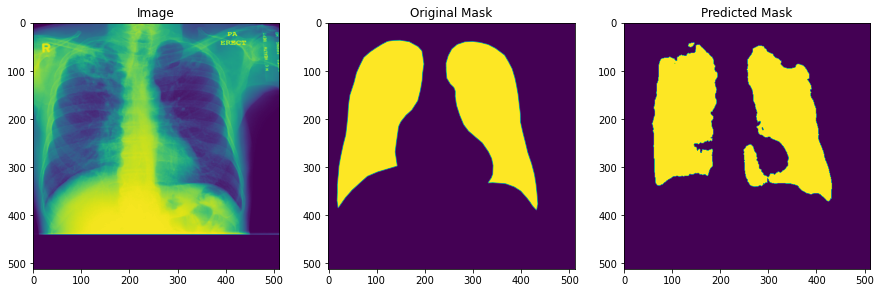

In [ ]:
# here the mask is binary 0/1

pred = (torch.sigmoid(masks_pred) > 0.5).float()
_, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(imgs[0].squeeze())
ax[0].title.set_text('Image')
ax[1].imshow(true_masks[0].squeeze())
ax[1].title.set_text('Original Mask')
ax[2].imshow(pred[0].detach().cpu().squeeze())
ax[2].title.set_text('Predicted Mask')

### v3

threshold = 0.2

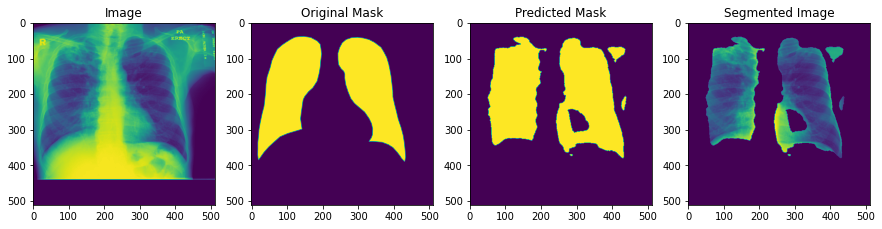

In [ ]:
#@title

threshold = 0.2
pred = (torch.sigmoid(masks_pred) > threshold).float()
_, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(imgs[0].squeeze())
ax[0].title.set_text('Image')
ax[1].imshow(true_masks[0].squeeze())
ax[1].title.set_text('Original Mask')
ax[2].imshow(pred[0].detach().cpu().squeeze())
ax[2].title.set_text('Predicted Mask')
ax[3].imshow(pred[0].detach().cpu().squeeze()*imgs[0].squeeze())
ax[3].title.set_text('Segmented Image')

### v4

threshold 0.1

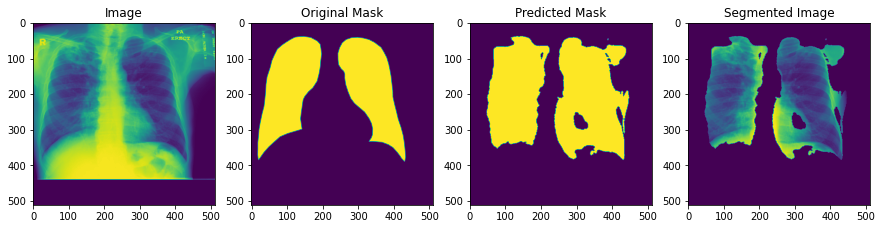

In [ ]:
#@title

threshold = 0.1
pred = (torch.sigmoid(masks_pred) > threshold).float()
_, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(imgs[0].squeeze())
ax[0].title.set_text('Image')
ax[1].imshow(true_masks[0].squeeze())
ax[1].title.set_text('Original Mask')
ax[2].imshow(pred[0].detach().cpu().squeeze())
ax[2].title.set_text('Predicted Mask')
ax[3].imshow(pred[0].detach().cpu().squeeze()*imgs[0].squeeze())
ax[3].title.set_text('Segmented Image')

# NIH Dataset

## download the data from kaggle

In [ ]:
# download data from kaggle 

! kaggle datasets download -d nih-chest-xrays/data

# unzip the data 

! unzip data.zip

## Sample segments 2

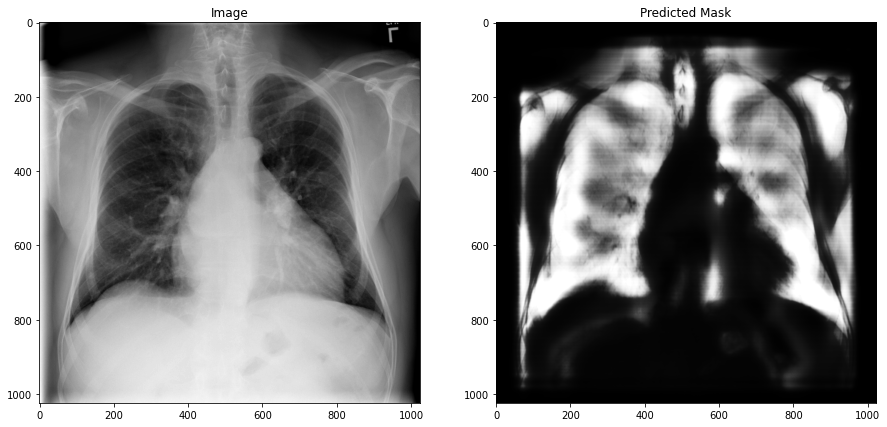

In [ ]:
sample = '/content/images_001/images/00000001_000.png'
#sample = '/content/images_002/images/00001336_000.png'
#sample = '/content/images_003/images/00003923_014.png'
#sample = '/content/images_004/images/00006585_007.png'
#sample = '/content/images_006/images/00011558_008.png'

import cv2
img = cv2.imread(sample, 0)
img_batch = transforms.ToTensor()(img)
img_batch = img_batch.unsqueeze(0)

masks_pred = model(img_batch.to(device))
pred = torch.sigmoid(masks_pred)

_, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].title.set_text('Image')
ax[1].imshow(pred[0].detach().cpu().squeeze(), cmap='gray')
ax[1].title.set_text('Predicted Mask')

### v1
threshold = 0.5

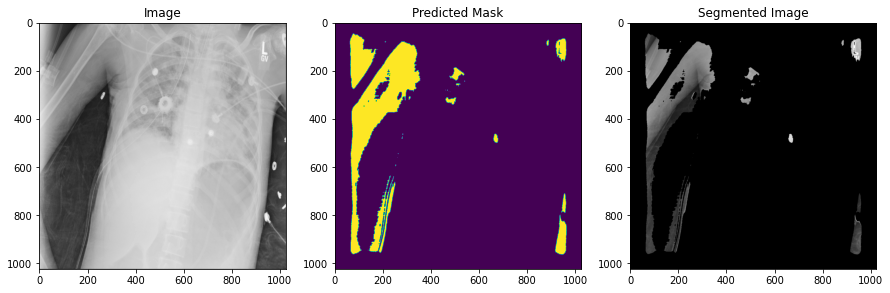

In [ ]:
#@title

threshold = 0.5
pred = (torch.sigmoid(masks_pred) > threshold).float()
_, ax = plt.subplots(1,3, figsize=(15,15))

ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].title.set_text('Image')
ax[1].imshow(pred[0].detach().cpu().squeeze())
ax[1].title.set_text('Predicted Mask')
ax[2].imshow(pred[0].detach().cpu().squeeze()*img.squeeze(), cmap='gray')
ax[2].title.set_text('Segmented Image')

### v2
threshold = 0.5

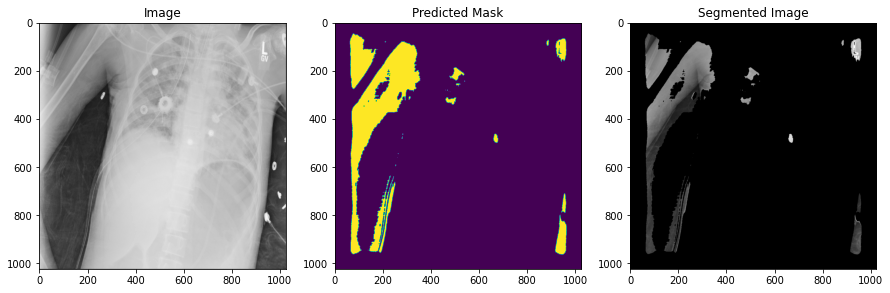

In [ ]:
#@title

threshold = 0.5
pred = (torch.sigmoid(masks_pred) > threshold).float()
_, ax = plt.subplots(1,3, figsize=(15,15))

ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].title.set_text('Image')
ax[1].imshow(pred[0].detach().cpu().squeeze())
ax[1].title.set_text('Predicted Mask')
ax[2].imshow(pred[0].detach().cpu().squeeze()*img.squeeze(), cmap='gray')
ax[2].title.set_text('Segmented Image')

In [ ]:
#@title
# % of ones indicate the amount of information 

types, (num_zeros, num_ones) = np.unique(pred[0].detach().cpu().squeeze().numpy(), return_counts=True)
print(f'% of ones is {num_ones/(num_ones+num_zeros)*100}')

% of ones is 9.965991973876953


### v3
threshold 0.1

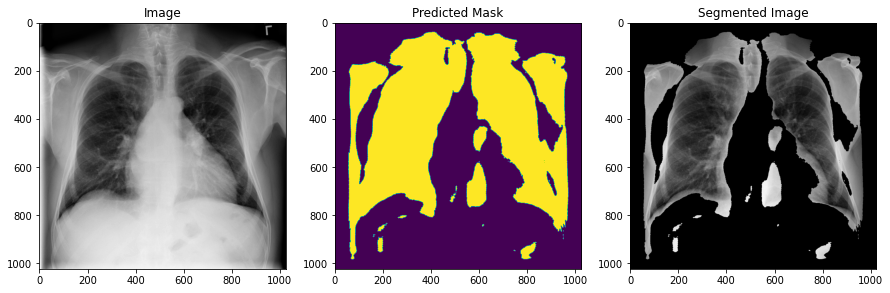

In [ ]:
#@title

threshold = 0.1
pred = (torch.sigmoid(masks_pred) > threshold).float()
_, ax = plt.subplots(1,3, figsize=(15,15))

ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].title.set_text('Image')
ax[1].imshow(pred[0].detach().cpu().squeeze())
ax[1].title.set_text('Predicted Mask')
ax[2].imshow(pred[0].detach().cpu().squeeze()*img.squeeze(), cmap='gray')
ax[2].title.set_text('Segmented Image')

In [ ]:
#@title
# % of ones indicate the amount of information 

types, (num_zeros, num_ones) = np.unique(pred[0].detach().cpu().squeeze().numpy(), return_counts=True)
print(f'% of ones is {num_ones/(num_ones+num_zeros)*100}')

% of ones is 43.15967559814453


In [ ]:
import pandas as pd
import numpy as np
import os
from os import path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from scipy import interp
from itertools import cycle
from glob import glob
from itertools import chain

# pytorch imports
import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

## Pre-process data

In [ ]:
labels_path = '/content/Data_Entry_2017.csv'
train_path = '/content/train_val_list.txt' 
test_path = '/content/test_list.txt'

all_xray_df = pd.read_csv(labels_path)
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/content/', 'images*', '*', '*.png'))}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]

label_and_counts = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())), return_counts=True)
label_and_counts_df = pd.DataFrame({'Label': label_and_counts[0], 'Count':label_and_counts[1]})
condition = label_and_counts_df.Count >= MIN_CASES
label_and_counts_df = label_and_counts_df[condition].sort_values(by='Count', ascending=False)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# get the segment area for all the images in the dataset 
%%time

def get_segmentedarea(df, threshold):
  segmented_file_area = {'path':[], 'area':[]}
  for path in df:
    img = cv2.imread(path, 0)
    img_batch = transforms.ToTensor()(img)
    img_batch = img_batch.unsqueeze(0)

    masks_pred = model(img_batch.to(device)) 
    pred = (torch.sigmoid(masks_pred) > threshold).float()
    
    types, (num_zeros, num_ones) = np.unique(pred[0].detach().cpu().squeeze().numpy(), return_counts=True)
    area_of_mask = round(num_ones/(num_ones+num_zeros)*100,2)
    segmented_file_area['path'].append(path)
    segmented_file_area['area'].append(area_of_mask)  

  segmented_file_area = pd.DataFrame(segmented_file_area)
  segmented_file_area.to_csv('/content/drive/MyDrive/Projects/DS5500/segmented_file_area.csv', index=False)
  return segmented_file_area

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.78 µs


In [ ]:
threshold = 0.1
segmented_file_area = get_segmentedarea(all_xray_df['path'][0:5], threshold)

In [ ]:
segmented_file_area

,path,area
0,/content/images_001/images/00000001_000.png,43.16
1,/content/images_001/images/00000001_001.png,47.48
2,/content/images_001/images/00000001_002.png,33.02
3,/content/images_001/images/00000002_000.png,45.07
4,/content/images_001/images/00000003_000.png,45.89


## Train/Val/Test dataframes

In [ ]:
train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))

train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))


train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])

train 90817 validation 10091 test 11212


In [ ]:
%%time

threshold = 0.1
segmented_file_area = get_segmentedarea(test_df['path'], threshold)

CPU times: user 20min 17s, sys: 10min 54s, total: 31min 12s
Wall time: 30min 59s


In [ ]:
segmented_file_area.shape

(11212, 2)

## Transforms

In [ ]:
transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.229])
])

transform_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.229])
        ])

## Create a segmented dataset

In [ ]:
import torchvision.transforms.functional as F

class NoneTransform(object):    
    def __call__(self, image):       
        return image

class NIHDataset:
    def __init__(
        self,
        image_paths,
        labels,
        resize,
        model,
        torch_augs=None,
        augmentations=None,
        backend="cv2",
        channel_first= True,
    ):        
        self.image_paths = image_paths        
        self.labels = labels
        self.resize = resize        
        self.torch_augs = torch_augs
        self.augmentations = augmentations
        self.backend = backend
        self.channel_first = channel_first
        self.model = model
        self.model.eval()
        self.model.to('cuda')
        self.threshold = 0.2

    def __len__(self):
        return len(self.image_paths)    

    def __getitem__(self, item):
        targets = self.labels[item]

        if self.backend == "pil":
            image = Image.open(self.image_paths[item]).convert("RGB")  
            segmented_image = Image.open(self.image_paths[item]).convert("L")                       

            if self.resize is not None:
                image = image.resize(
                    (self.resize[1], self.resize[0]), resample=Image.BILINEAR
                )
            if self.augmentations is not None:
                image = np.array(image)
                augmented = self.augmentations(image=image)
                image = augmented["image"]
                
            if self.torch_augs is not None:
                image = self.torch_augs(image)                
                segmented_image = transforms.Compose([transforms.Resize(256),
                                                      transforms.CenterCrop(224),
                                                      transforms.ToTensor(),])(segmented_image)

                masks_pred = self.model(segmented_image.unsqueeze(0).to('cuda'))            
                pred = (torch.sigmoid(masks_pred[0]) > self.threshold).float()                
                segmented_image = pred.detach().cpu()*image           
        
        elif self.backend == "cv2":
            image = cv2.imread(self.image_paths[item])            
            
            if self.resize is not None:
                image = cv2.resize(
                    image,
                    (self.resize[1], self.resize[0]),
                    interpolation=cv2.INTER_CUBIC,
                )
            
            if self.augmentations is not None:
                image = np.array(image)
                augmented = self.augmentations(image=image)
                image = augmented["image"]
            if self.torch_augs is not None:
                image = self.torch_augs(image)
        
        else:
            raise Exception("Backend not implemented")
        
        if self.channel_first:
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return image, segmented_image, torch.tensor(np.array(targets, dtype='float'))

## Train/Val/Test dataset

In [ ]:
trainset = NIHDataset(train_df['path'], 
                      train_df['disease_vec'],  
                      resize= None,
                      model =  model,
                      torch_augs=transform_train,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

validset = NIHDataset(valid_df['path'], 
                      valid_df['disease_vec'],  
                      resize= None, 
                      model = model,
                      torch_augs=transform_val,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

testset = NIHDataset(test_df['path'], 
                      test_df['disease_vec'],  
                      resize= None, 
                      model = model,
                      torch_augs=transform_val,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

bs = 16

trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
valloader = DataLoader(validset, batch_size=8, shuffle=True)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

## Sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
['Effusion']


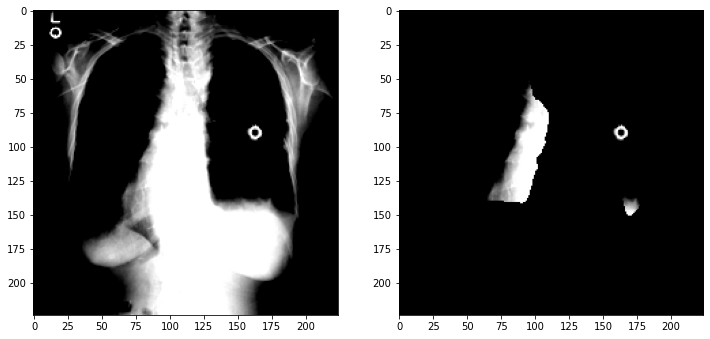

In [ ]:
i=5
test_images, test_segmented_images, test_labels = next(iter(trainloader))

all_labels_in_image = list(np.where(test_labels[i].numpy() == 1.)[0])
print('Label: ', test_labels[2].numpy())
print(np.array(all_labels)[all_labels_in_image])

_, ax = plt.subplots(1,2, figsize=(12,12))
x = np.transpose(test_images[0], (1,2,0))
y = np.transpose(test_segmented_images[0], (1,2,0))

ax[0].imshow(x, cmap='gray')
ax[1].imshow(y, cmap='gray')

In [ ]:
print(test_images.shape, test_segmented_images.shape, test_labels.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224]) torch.Size([8, 14])


Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
['Nodule']


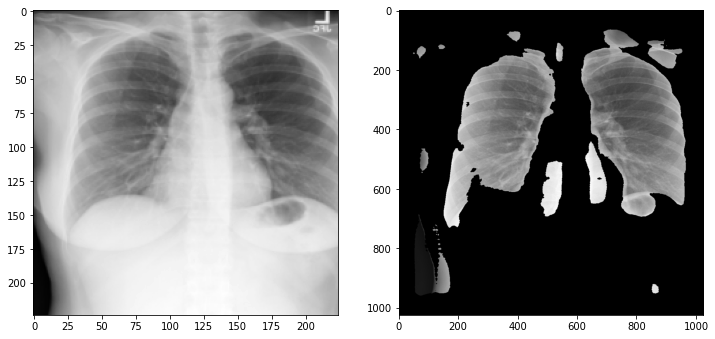

In [ ]:
#@title

i=2
test_images, test_segmented_images, test_labels = next(iter(trainloader))
all_labels_in_image = list(np.where(test_labels[i].numpy() == 1.)[0])
print('Label: ', test_labels[2].numpy())
print(np.array(all_labels)[all_labels_in_image])

_, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(test_images[0].squeeze(), cmap='gray')
ax[1].imshow(test_segmented_images[0].squeeze(), cmap='gray')

Label:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
['Effusion' 'Emphysema' 'Infiltration']


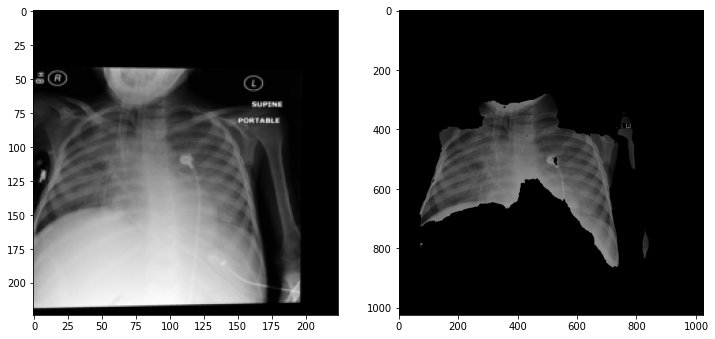

In [ ]:
#@title

i=5
test_images, test_segmented_images, test_labels = next(iter(trainloader))
all_labels_in_image = list(np.where(test_labels[i].numpy() == 1.)[0])
print('Label: ', test_labels[2].numpy())
print(np.array(all_labels)[all_labels_in_image])

_, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(test_images[0].squeeze(), cmap='gray')
ax[1].imshow(test_segmented_images[0].squeeze(), cmap='gray')

Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
['No Finding']


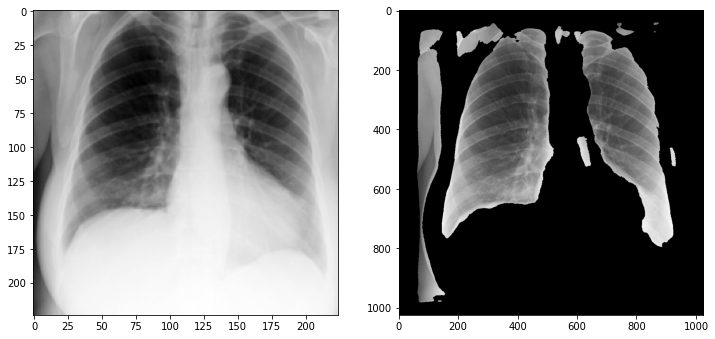

In [ ]:
#@title

i=5
test_images, test_segmented_images, test_labels = next(iter(trainloader))
all_labels_in_image = list(np.where(test_labels[i].numpy() == 1.)[0])
print('Label: ', test_labels[2].numpy())
print(np.array(all_labels)[all_labels_in_image])

_, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(test_images[0].squeeze(), cmap='gray')
ax[1].imshow(test_segmented_images[0].squeeze(), cmap='gray')

In [ ]:
path = '/content/drive/MyDrive/Projects/DS5500/'

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
model2 = torchvision.models.vgg16(pretrained=True)
set_parameter_requires_grad(model2, True)
n_classes = len(all_labels)
model2.classifier[6] = nn.Linear(4096,n_classes)

checkpoint = torch.load(path + 'VGG_NIH_TrainFinalParam-v2.pth.tar')
model2.load_state_dict(checkpoint['state_dict'])
model2.to(device)

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

model2 = EfficientNet.from_name('efficientnet-b4')
set_parameter_requires_grad(model, True)
n_classes = len(all_labels)
model2._fc = nn.Linear(1792,n_classes)

#checkpoint = torch.load(path + 'Efficientnetb4_NIH_TrainAllParam.pth.tar')
#model2.load_state_dict(checkpoint['state_dict'])
model2.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def train(model, num_epochs, trainloader, valloader):  
  all_statistics = {'training':{'loss': {key+1:[] for key in range(num_epochs)}, 'accuracy': {key+1:[] for key in range(num_epochs)}}, 
                  'validation':{'loss': {key+1:[] for key in range(num_epochs)}, 'accuracy': {key+1:[] for key in range(num_epochs)}}}

  training_statistics = {'loss':[],'accuracy':[], 'probability':[], 'logits':[], 'label':[]}
  validation_statistics = {'loss':[],'accuracy':[], 'probability':[], 'logits':[], 'label':[]}
  for epoch in range(num_epochs):
    losses = list()
    accuracy = list()
    correct = 0

    model.train()
    for i, batch in enumerate(trainloader):
      image, segmented_image, label = batch
      segmented_image = segmented_image.to(device)
      label = label.to(device) 

      # 1. forward
      output = model(segmented_image)
      # debugging 
      #import pdb; pdb.set_trace()
      # 2. objective function    
      loss = criterion(output, label)                 # The output from the model will be bsx3072 hence changing the dimension of image      
      # 3. clean gradients 
      model.zero_grad()
      # 4. accumulate gradients 
      loss.backward()
      # 5. optimizer
      optimizer.step()
      # get model accuracy, convert the logit output into 1,0 and then 
      output_logits = (torch.sigmoid(output)>0.5).float()
      correct = torch.sum(torch.sum(output_logits == label , 1) == 14) # 14 because there are 14 labels 

      losses.append(loss.item())   
      accuracy.append(correct/14)         
      training_statistics['loss'].append(loss.item())
      training_statistics['accuracy'].append(correct/14)
      training_statistics['probability'].append(torch.sigmoid(output.cpu()))      
      training_statistics['logits'].append(output_logits.cpu())            
      training_statistics['label'].append(label.cpu())            
      #import pdb; pdb.set_trace()
      if (i%100 == 0):
        print(f'Current training sample [{i}/{len(trainloader)}] loss: {loss.cpu().item()}')        
    
    all_statistics['training']['loss'][epoch+1].append(torch.tensor(losses).mean().item())
    all_statistics['training']['accuracy'][epoch+1].append(torch.tensor(accuracy).mean().item())

    print(f'Epoch {epoch + 1}, training loss: {torch.tensor(losses).mean():.2f}')
    print(f'Epoch {epoch + 1}, training accuracy: {torch.tensor(accuracy).mean():.2f}')
      

    model.eval()
    losses = list()
    accuracy = list()
    correct = 0

    for i, batch in enumerate(valloader):
      image, segmented_image, label = batch      
      segmented_image = segmented_image.to(device)
      label = label.to(device)

      # 1. forward
      with torch.no_grad():
        output = model(segmented_image)
      # 2. objective function
      loss = criterion(output, label)
      # get model accuracy, convert the logit output into 1,0 and then 
      output_logits = (torch.sigmoid(output)>0.5).float()
      correct = torch.sum(torch.sum(output_logits == label , 1) == 14) # 14 because there are 14 labels 

      losses.append(loss.item())
      accuracy.append(correct/14)  
      
      validation_statistics['loss'].append(loss.item())
      validation_statistics['accuracy'].append(correct/14)
      validation_statistics['probability'].append(torch.sigmoid(output.cpu()))      
      validation_statistics['logits'].append(output_logits.cpu())            
      validation_statistics['label'].append(label.cpu())  

    all_statistics['validation']['loss'][epoch+1].append(torch.tensor(losses).mean().item())
    all_statistics['validation']['accuracy'][epoch+1].append(torch.tensor(accuracy).mean().item())

    print(f'Epoch {epoch + 1}, validation loss: {torch.tensor(losses).mean():.2f}')
    print(f'Epoch {epoch + 1}, validation accuracy: {torch.tensor(accuracy).mean():.2f}')

  return model, all_statistics, training_statistics, validation_statistics

In [ ]:
num_epochs = 5
model, all_statistics, training_statistics, validation_statistics = train(model2, num_epochs, trainloader, valloader)

Current training sample [0/11353] loss: 0.7409433707278886
Current training sample [100/11353] loss: 0.7111141024589804
Current training sample [200/11353] loss: 0.7262420709344691
Current training sample [300/11353] loss: 0.7199434465895007
Current training sample [400/11353] loss: 0.7232547097498484
Current training sample [500/11353] loss: 0.7332502857981515
Current training sample [600/11353] loss: 0.7291027270797972
Current training sample [700/11353] loss: 0.7122031782387889
Current training sample [800/11353] loss: 0.729238227857942
Current training sample [900/11353] loss: 0.7170687746630782
Current training sample [1000/11353] loss: 0.7262527591665275
Current training sample [1100/11353] loss: 0.7356104723876342
Current training sample [1200/11353] loss: 0.722948687733151
Current training sample [1300/11353] loss: 0.7348881088130708
Current training sample [1400/11353] loss: 0.7295076496832604
Current training sample [1500/11353] loss: 0.7195469634940049
Current training sampl

KeyboardInterrupt: ignored

## save model

In [ ]:
torch.save(model.state_dict(), path + 'Efficient-net_NIH_TrainFinalParam-v1-using_segments.pt')

## load model

In [ ]:
def test(model, testloader):
  model.eval()
  with torch.no_grad():
    losses = list()
    accuracy = list()    
    test_statistics = {'loss':[],'accuracy':[], 'probability':[], 'logits':[], 'label':[]}
    for batch in testloader:
      image, segmented_image, label = batch
      image, segmented_image, label = image.to(device), segmented_image.to(device), label.to(device)

      output = model(segmented_image)
      loss = criterion(output, label)
      
      output_logits = (torch.sigmoid(output)>0.5).float()
      correct = torch.sum(torch.sum(output_logits == label , 1) == 14) # 14 because there are 14 labels 

      losses.append(loss.item())
      accuracy.append(correct/14)

      test_statistics['loss'].append(loss.item())
      test_statistics['accuracy'].append(correct/14)
      test_statistics['probability'].append(torch.sigmoid(output.cpu()))      
      test_statistics['logits'].append(output_logits.cpu())            
      test_statistics['label'].append(label.cpu()) 

  print(f'Average test loss: {torch.tensor(losses).mean()}')
  print(f'Average test accuracy: {torch.tensor(accuracy).mean()}')
  return test_statistics

In [ ]:
# original efficient-net model using full images 

test_statistics1 = test(model2, testloader)

Average test loss: 0.22980143129825592
Average test accuracy: 0.3058896064758301


In [ ]:
# here probability is the sigmoid 14 class probability and label is the true ouput

y_pred = test_statistics1['probability']
y_pred = torch.cat(y_pred, axis=0)

y_truelabel = test_statistics1['label']
y_truelabel = torch.cat(y_truelabel, axis=0)

y_predlabel = test_statistics1['logits']
y_predlabel = torch.cat(y_predlabel, axis=0)

In [ ]:
path = '/content/drive/MyDrive/Projects/DS5500/'

model2 = torchvision.models.vgg16(pretrained=True)
set_parameter_requires_grad(model2, True)
n_classes = len(all_labels)
model2.classifier[6] = nn.Linear(4096,n_classes)

model2.load_state_dict(torch.load(path + 'VGG_NIH_TrainFinalParam-v2-using_segments.pt'))
model2.eval()
model2.to(device)

In [ ]:
# original vgg model using segment images

test_statistics2 = test(model2, testloader)

Average test loss: 0.23099321126937866
Average test accuracy: 0.20394335687160492


In [ ]:
path = '/content/drive/MyDrive/Projects/DS5500/'

model2 = torchvision.models.vgg16(pretrained=True)
set_parameter_requires_grad(model2, True)
n_classes = len(all_labels)
model2.classifier[6] = nn.Linear(4096,n_classes)

checkpoint = torch.load(path + 'VGG_NIH_TrainFinalParam-v2.pth.tar')
model2.load_state_dict(checkpoint['state_dict'])
model2.to(device)

In [ ]:
# original vgg model using full images

test_statistics3 = test(model2, testloader)

Average test loss: 0.21889790892601013
Average test accuracy: 0.20750971138477325


In [ ]:
# here probability is the sigmoid 14 class probability and label is the true ouput

y_pred = test_statistics3['probability']
y_pred = torch.cat(y_pred, axis=0)

y_truelabel = test_statistics3['label']
y_truelabel = torch.cat(y_truelabel, axis=0)

y_predlabel = test_statistics3['logits']
y_predlabel = torch.cat(y_predlabel, axis=0)

## ROC

In [ ]:
def plot_roc(y_test, y_score, title):

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(12,8))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'yellow', 'gray', 'lime', 'black', 'gold', 'cyan', 'violet', 'teal'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(all_labels[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

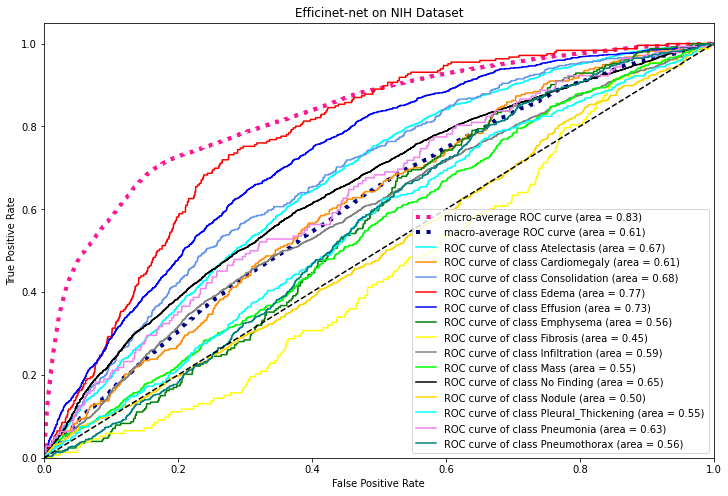

In [ ]:
plot_roc(y_truelabel, y_pred, 'Efficinet-net on NIH Dataset')

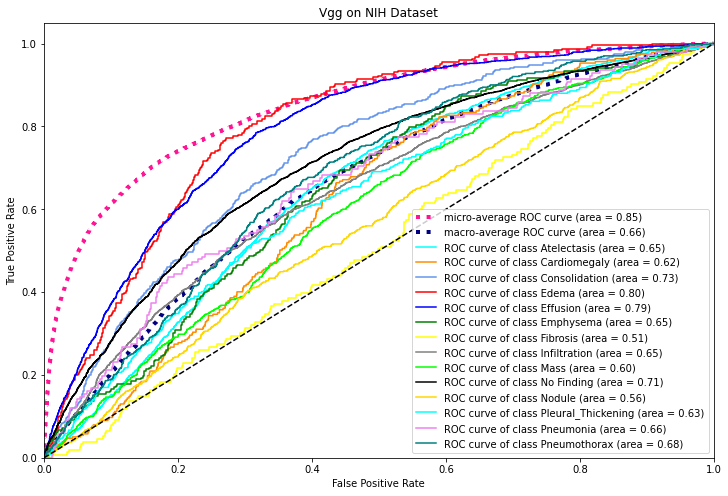

In [ ]:
plot_roc(y_truelabel, y_pred, 'Vgg on NIH Dataset')

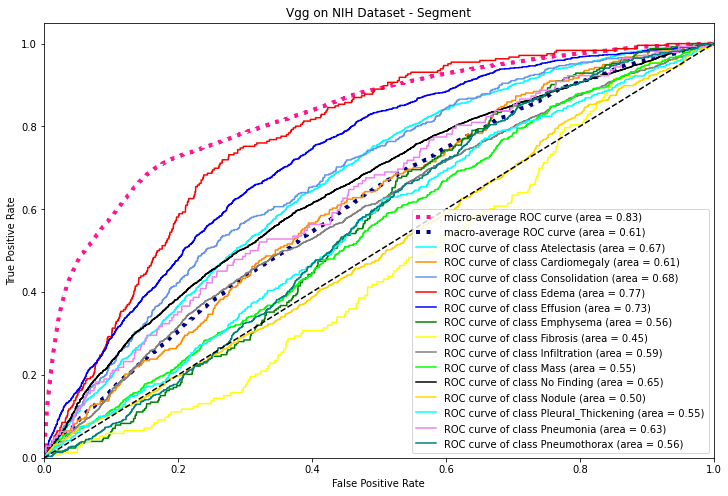

In [ ]:
plot_roc(y_truelabel, y_pred, 'Vgg on NIH Dataset - Segment')

# References 

https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

https://github.com/seungjunlee96/U-Net_Lung-Segmentation

https://stackoverflow.com/questions/48796169/how-to-fix-ipykernel-launcher-py-error-unrecognized-arguments-in-jupyter

https://stackoverflow.com/questions/49035156/pytorch-how-to-use-topilimage-correctly

https://scikit-learn.org/dev/auto_examples/model_selection/plot_roc.html